In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn import svm, linear_model, datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt  

In [2]:
loans_raw = pd.read_csv("https://raw.githubusercontent.com/mrbarron3/stat451/main/loan_data.csv")
loans_p = loans_raw[["purpose", "int.rate", "installment", "log.annual.inc", "dti", "fico", "days.with.cr.line", "revol.bal", "delinq.2yrs", "not.fully.paid"]]

loans = loans_p.join(pd.get_dummies(loans_p.purpose))
loans = loans.drop("purpose", axis=1)

header = list(loans.columns)

In [3]:
loans.head()

,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,delinq.2yrs,not.fully.paid,all_other,credit_card,debt_consolidation,educational,home_improvement,major_purchase,small_business
0,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,0,0,0,0,1,0,0,0,0
1,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,0,0,0,1,0,0,0,0,0
2,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,0,0,0,0,1,0,0,0,0
3,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,0,0,0,0,1,0,0,0,0
4,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,1,0,0,1,0,0,0,0,0


In [4]:
X = loans.drop(columns=['not.fully.paid'])
y = loans['not.fully.paid']

X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=.2,
                                                  random_state=0, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_tmp, y_tmp, test_size=.5,
  random_state=0, stratify=y_tmp)

In [5]:
classifiers = [
    linear_model.LogisticRegression(max_iter=5000), 
    DecisionTreeClassifier(), 
    KNeighborsClassifier()
]
parameters = [ 
    {'C': [0.01, 1, 100]},
    {'criterion': ['entropy'], 'max_depth': [1, 3, 5, 7]},
    {'n_neighbors': [1, 2, 3, 4]}
]

best_idx = -1
best_accuracy = -np.Inf
best_clf = None

for i in range(len(classifiers)):
    if isinstance(classifiers[i], svm.SVC):
        clf = RandomizedSearchCV(classifiers[i], parameters[i])
    else:
        clf = GridSearchCV(classifiers[i], parameters[i])
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_valid, y_valid)    
    print(accuracy)
    if np.any(accuracy > best_accuracy):
        best_idx = i
        best_accuracy = accuracy 
        best_clf = clf
        best_params = clf.best_params_
    elif np.all(accuracy == best_accuracy):
        if type(best_clf) != list:
            best_idx = [best_idx, i]
            best_accuracy = [best_accuracy, accuracy] 
            best_clf = [best_clf, clf]
            best_params = [best_params, clf.best_params_]
        
print(f'The best classifiers are {[classifiers[best_idx[0]], classifiers[best_idx[1]]]} with the parameters {best_params}')

0.8392484342379958
0.8392484342379958
0.826722338204593
The best classifiers are [LogisticRegression(max_iter=5000), DecisionTreeClassifier()] with the parameters [{'C': 0.01}, {'criterion': 'entropy', 'max_depth': 1}]


In [9]:
model = linear_model.Lasso()

model.fit(X_train, y_train)
MSE_train = (1/y_train.size) * np.sum((y_train - model.predict(X_train))**2)
MSE_test = (1/y_test.size)  * np.sum((y_test - model.predict(X_test))**2) 
w = model.coef_[1:] 
intercept = model.intercept_

print(f"MSE train: {MSE_train}, MSE test: {MSE_test}")

print(f"The coefficients are {w}")
print(f"These coefficients match up with these header names: {header}")

non_zero_vars = []
for i in range(len(w)):
    if np.isclose(w[i], 0):
        continue
    non_zero_vars.append(header[i])
    
non_zero_vars

MSE train: 0.13147711998737657, MSE test: 0.13192819345166515
The coefficients are [ 6.53160565e-05 -0.00000000e+00  0.00000000e+00 -6.87583788e-04
 -4.19157057e-06  5.89215996e-07  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00]
These coefficients match up with these header names: ['int.rate', 'installment', 'log.annual.inc', 'dti', 'fico', 'days.with.cr.line', 'revol.bal', 'delinq.2yrs', 'not.fully.paid', 'all_other', 'credit_card', 'debt_consolidation', 'educational', 'home_improvement', 'major_purchase', 'small_business']


['int.rate', 'dti', 'fico', 'days.with.cr.line']

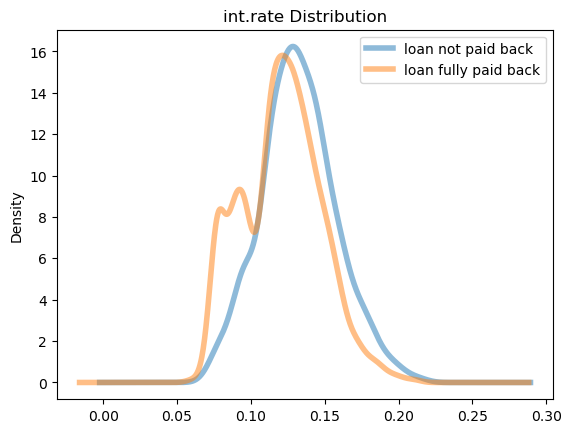

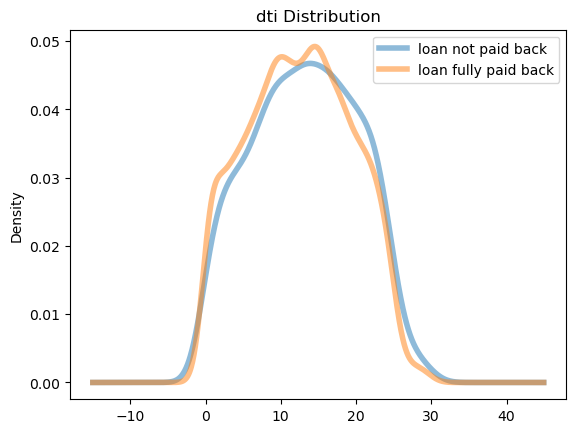

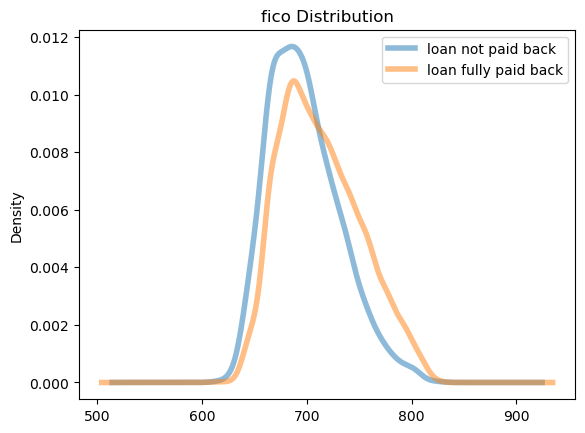

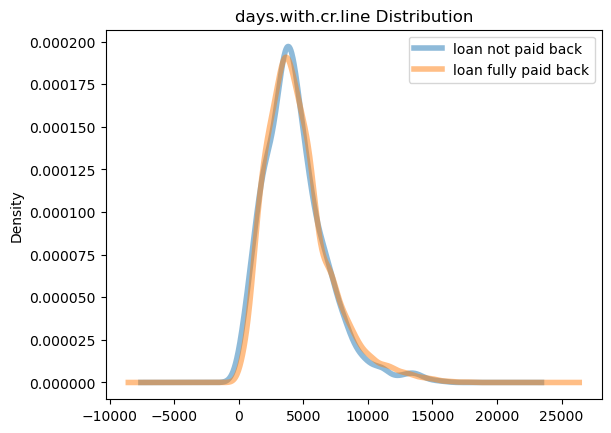

In [7]:
for var in non_zero_vars:
    loans[loans["not.fully.paid"] == 1][var].plot(kind = 'density', alpha = 0.5, label = 'loan not paid back', linewidth=4)
    loans[loans["not.fully.paid"] == 0][var].plot(kind = 'density', alpha = 0.5, label = 'loan fully paid back', linewidth=4)
    
    plt.title(f"{var} Distribution")
    plt.legend()
    plt.show(block=False)